In [1]:
import pandas as pd
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
# !pip install pyLDAvis

In [2]:
review_df = pd.read_csv('./train_noun.csv')
review_df.head()

,recipe_id,user_id,name,date,review,processed_review,noun_review
0,5315,8629,icy holiday punch,2001-04-24,I brought this to an office holiday party and ...,"['brought', 'office', 'holiday', 'party', 'eve...","['office', 'party', 'holiday']"
1,8661,13483,oliveau salad dressing,2001-08-05,Good recipe and easy to make. I found it a li...,"['good', 'recipe', 'easy', 'make', 'found', 'l...","['make', 'wine', 'dilute', 'salad']"
2,10859,8629,broccoli cauliflower and rice casserole,2001-08-15,This is a nice casserole. It is very easy to ...,"['nice', 'casserole', 'easy', 'put', 'together']","['casserole', 'put']"
3,902,13483,microwaved garlic mushroom rolls,2001-08-16,Very easy to make for a lunch. I served it co...,"['easy', 'make', 'lunch', 'served', 'cold', 's...","['cheddar', 'sandwich', 'lunch', 'cheese']"
4,10722,13483,cherry cream cheese pie,2001-09-04,I like easy and good. I bought the pie shell ...,"['like', 'easy', 'good', 'bought', 'pie', 'she...","['shell', 'town', 'good', 'guest', 'whip', 'pie']"


# Create Corpus

In [3]:
# change noun review to list
def str_to_list(text):
    text = text[1:len(text)-1]
    text_list = text.split(',')
    text_list = [text.strip()[1:-1] for text in text_list]
    return text_list

In [4]:
data_lemmatized = review_df['noun_review'].tolist()
data_lemmatized = [str_to_list(text) for text in data_lemmatized]
data_lemmatized[:10]

[['office', 'party', 'holiday'],
 ['make', 'wine', 'dilute', 'salad'],
 ['casserole', 'put'],
 ['cheddar', 'sandwich', 'lunch', 'cheese'],
 ['shell', 'town', 'good', 'guest', 'whip', 'pie'],
 ['potato'],
 ['chicken', 'marinade', 'sauce'],
 ['beat', 'stuff'],
 ['lemon', 'week', 'blueberry'],
 ['pm', 'stuff']]

In [5]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [6]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'holiday'), (1, 'office'), (2, 'party'), (3, 'dilute'), (4, 'make'), (5, 'salad'), (6, 'wine'), (7, 'casserole'), (8, 'put'), (9, 'cheddar'), (10, 'cheese'), (11, 'lunch'), (12, 'sandwich'), (13, 'good'), (14, 'guest'), (15, 'pie'), (16, 'shell'), (17, 'town'), (18, 'whip'), (19, 'potato'), (20, 'chicken'), (21, 'marinade'), (22, 'sauce'), (23, 'beat'), (24, 'stuff'), (25, 'blueberry'), (26, 'lemon'), (27, 'week'), (28, 'pm'), (29, 'flavour'), (30, 'friend'), (31, 'ketchup'), (32, 'lot'), (33, 'share'), (34, 'versitile'), (35, 'coffee'), (36, 'dessert'), (37, 'night'), (38, 'doubt'), (39, 'mustard'), (40, 'desert'), (41, 'bean'), (42, 'corn'), (43, 'day'), (44, 'rice'), (45, 'side'), (46, 'winner'), (47, 'eater'), (48, 'fish'), (49, 'love')]

Total Vocabulary Size: 8108


# Building LDA Model

## Hyperparameter Tuning for LDA Model

In [7]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    log_perplexity = lda_model.log_perplexity(corpus)
    perplexity = 2**(-log_perplexity)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [8]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.3118364576126177
Perplexity Score:  120.38246541969998

topic number:  3
Coherence Score:  0.3487214222150814
Perplexity Score:  123.51238124969672

topic number:  4
Coherence Score:  0.39904777984600626
Perplexity Score:  127.47977133289552

topic number:  5
Coherence Score:  0.3892415271980576
Perplexity Score:  133.11835973973533

topic number:  6
Coherence Score:  0.445932246473062
Perplexity Score:  135.64320302615613

topic number:  7
Coherence Score:  0.4391237011129565
Perplexity Score:  140.37394238960087

topic number:  8
Coherence Score:  0.42011849312269145
Perplexity Score:  144.95787398820232

topic number:  9
Coherence Score:  0.46148653353003943
Perplexity Score:  149.64128622065007

topic number:  10
Coherence Score:  0.4526091481768416
Perplexity Score:  165.9349364084222

topic number:  11
Coherence Score:  0.43955009674603274
Perplexity Score:  190.6526132098078

topic number:  12
Coherence Score:  0.43485439123852426
Perplexity 

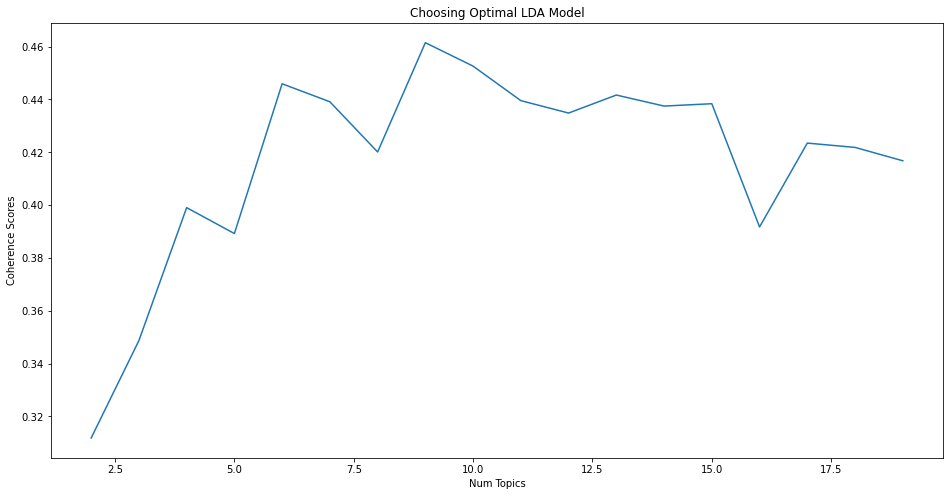

In [9]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

## Final LDA Model

In [10]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=9, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [11]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"bread" + 0.028*"texture" + 0.027*"flour" + 0.025*"butter" + '
  '0.023*"chocolate" + 0.021*"sugar" + 0.020*"cookie" + 0.020*"chip" + '
  '0.019*"dough" + 0.018*"cake"'),
 (1,
  '0.047*"game" + 0.038*"star" + 0.024*"lemon" + 0.022*"juice" + '
  '0.022*"flavor" + 0.018*"taste" + 0.016*"holiday" + 0.015*"rating" + '
  '0.015*"zwt" + 0.015*"event"'),
 (2,
  '0.040*"photo" + 0.031*"oil" + 0.028*"herb" + 0.026*"olive" + '
  '0.018*"flavour" + 0.018*"flavor" + 0.017*"combination" + 0.015*"garden" + '
  '0.015*"love" + 0.014*"cooking"'),
 (3,
  '0.030*"sugar" + 0.029*"cream" + 0.019*"vanilla" + 0.019*"drink" + '
  '0.018*"dessert" + 0.018*"apple" + 0.016*"flavor" + 0.016*"ice" + '
  '0.015*"milk" + 0.015*"fruit"'),
 (4,
  '0.034*"sauce" + 0.028*"pepper" + 0.027*"rice" + 0.023*"flavor" + '
  '0.022*"chicken" + 0.020*"soup" + 0.019*"salt" + 0.019*"garlic" + '
  '0.019*"tomato" + 0.018*"onion"'),
 (5,
  '0.045*"salad" + 0.034*"lunch" + 0.029*"day" + 0.025*"dinner" + '
  '0.023*"nig

In [12]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [13]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(review_df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])

In [14]:
review_df['Doc'] = doc_num
review_df['Topic'] = topic_num
review_df['Probability'] = prob

In [15]:
df_final = review_df[['recipe_id', 'name', 'date', 'review', 'Doc', 'Topic', 'Probability']]
df_final

,recipe_id,name,date,review,Doc,Topic,Probability
0,5315,icy holiday punch,2001-04-24,I brought this to an office holiday party and ...,0,5,0.469817
1,8661,oliveau salad dressing,2001-08-05,Good recipe and easy to make. I found it a li...,1,2,0.822104
2,10859,broccoli cauliflower and rice casserole,2001-08-15,This is a nice casserole. It is very easy to ...,2,4,0.703589
3,902,microwaved garlic mushroom rolls,2001-08-16,Very easy to make for a lunch. I served it co...,3,5,0.822199
4,10722,cherry cream cheese pie,2001-09-04,I like easy and good. I bought the pie shell ...,4,3,0.872971
...,...,...,...,...,...,...,...
72252,349813,healthier french fries and budget friendly,2010-09-08,This is a really nice basic fries recipe. I li...,72252,2,0.363677
72253,76930,funky chicken with sesame noodles,2010-09-08,Fantastic! My boys devoured it! I used light s...,72253,7,0.466679
72254,214193,no egg tomato soup cake,2010-09-08,"Oh wow, this is a really, really good cake rec...",72254,2,0.279980
72255,177792,chili potato dippers with cheddar jalapeno dip,2010-09-08,"Mmm, yummy!!!! The fries are so spicy and yumm...",72255,8,0.285588


## Model Evaluation

In [16]:
# Compute Perplexity
log_perplexity = lda_model.log_perplexity(corpus)
perplexity = 2**(-log_perplexity)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  153.16232427913314
Coherence Score:  0.43556165552407644


In [23]:
df_final.to_csv("topic_modelling_all_noun.csv", index=False)

# Visualisation

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.174987  0.025757       1        1  17.690551
0      0.153680 -0.052710       2        1  12.801886
3      0.134752 -0.236583       3        1  11.818710
5     -0.035271  0.067247       4        1  11.011676
7     -0.124505  0.229856       5        1  10.720111
8     -0.183601 -0.082712       6        1  10.020136
1      0.082938 -0.100145       7        1   9.320091
6      0.271702  0.220012       8        1   8.339417
2     -0.124709 -0.070722       9        1   8.277424, topic_info=          Term         Freq        Total Category  logprob  loglift
20     chicken  6127.000000  6127.000000  Default  30.0000  30.0000
22       sauce  7262.000000  7262.000000  Default  29.0000  29.0000
1590      game  2809.000000  2809.000000  Default  28.0000  28.0000
76       cream  4244.000000  4244.000000  Default  27.0000  27.0000
4363       pac  3135.000000  3135.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
97      tomato   520.678319  3368.424848   Topic9  -4.6217   0.6246
55       onion   531.656586  4092.167767   Topic9  -4.6008   0.4508
19      potato   474.313957  3706.235286   Topic9  -4.7150   0.4357
477   addition   426.050856  2164.100610   Topic9  -4.8223   0.8664
73       taste   418.794294  5656.456543   Topic9  -4.8394  -0.1115

[527 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
110       6  0.997583          
1919      1  0.995482      abit
477       1  0.249526  addition
477       2  0.064692  addition
477       3  0.165427  addition
...     ...       ...       ...
7381      8  0.008557      zwt4
7381      9  0.685996      zwt4
8080      1  0.418280      zwt6
8080      4  0.144497      zwt6
8080      9  0.435663      zwt6

[864 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 6, 8, 9, 2, 7, 3])

## Word Count of Topic Keywords

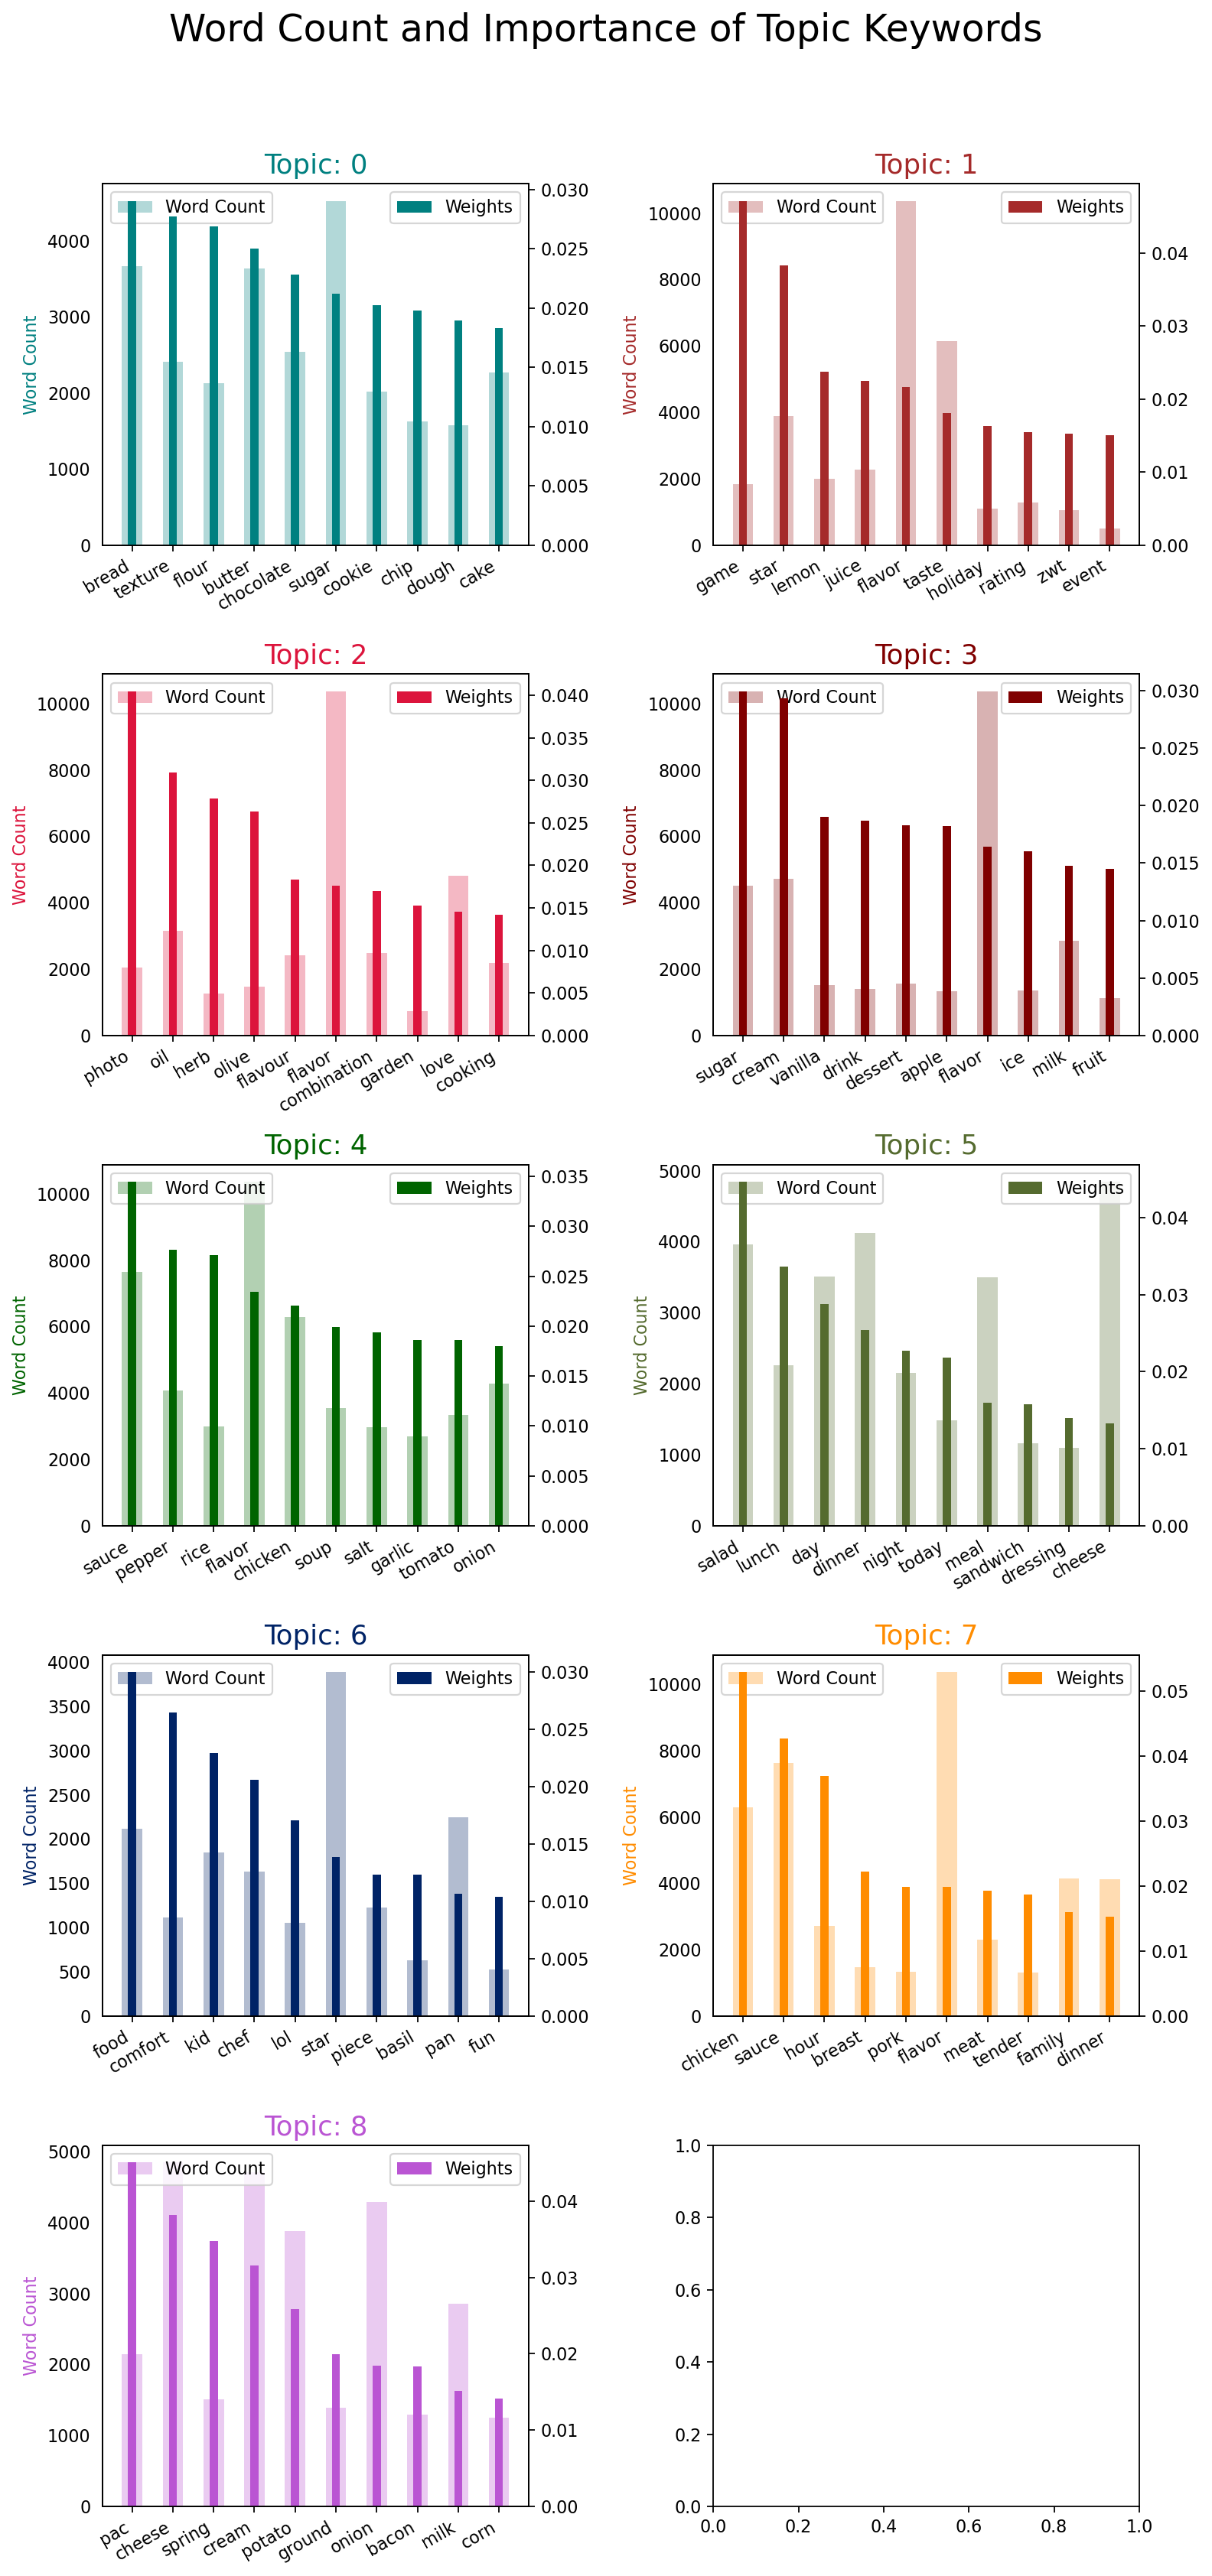

In [22]:
from collections import Counter

num_topics = 9

topics = lda_model.show_topics(num_topics=num_topics, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,20), dpi=160)
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', 
        '#ba55d3'] # '#b8860b', '#C71585', '#00ff7f', '#00004C']

for i, ax in enumerate(axes.flatten()):
    if i > num_topics - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()